## With toy dataset

In [1]:
from __future__ import print_function

In [2]:
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [5]:
# make plots a bit nicer
plt.matplotlib.rcParams.update({'font.size': 18, 'font.family': 'serif'})

In [6]:
# random seed settings
torch.manual_seed(42)
np.random.seed(42)

# data type (useful to have in pytorch)
dtype_np = np.float64
dtype_torch = torch.FloatTensor

##### Data load

In [11]:
data = np.loadtxt('data/toy_data/data_class_train.txt')
dataX = data[:,0:2]
dataY = data[:,2]

In [12]:
n_samples = data.shape[0]
dim_in = 2 # two features
dim_out = 3 # three classes

n_train = int(n_samples * 0.7)
n_test = n_samples - n_train

In [13]:
# train-test partition
perm = np.random.permutation(n_samples)
train_indx = perm[:n_train]
test_indx = perm[n_train:]

dataX_train, dataY_train = dataX[train_indx,:], dataY[train_indx]
dataX_test, dataY_test = dataX[test_indx,:], dataY[test_indx]

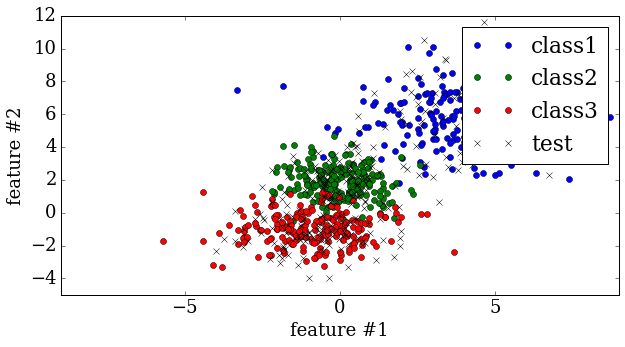

In [14]:
# visualize data
plt.figure(figsize=(10,5))
plt.plot(dataX_train[dataY_train==0,0], dataX_train[dataY_train==0,1],'ob', label="class1")
plt.plot(dataX_train[dataY_train==1,0], dataX_train[dataY_train==1,1],'og', label="class2")
plt.plot(dataX_train[dataY_train==2,0], dataX_train[dataY_train==2,1],'or', label="class3")

plt.plot(dataX_test[:,0], dataX_test[:,1],'xk', label="test")

plt.xlabel('feature #1')
plt.ylabel('feature #2')
plt.legend()
plt.xlim(-9, 9)
plt.ylim(-5, 12);

In [17]:
class Net(nn.Module):
    def __init__(self, dim_in, dim_hidden1, dim_hidden2, dim_out):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(dim_in, dim_hidden1)
        self.fc2 = nn.Linear(dim_hidden1, dim_hidden2)
        self.fc3 = nn.Linear(dim_hidden2, dim_out)
        self.fcws = nn.Linear(dim_in, dim_hidden2)
    def forward(self, x):
        x = F.relu(self.fc3(F.relu(self.fc2(F.tanh(self.fc1(x))))+ self.fcws(x)))# Ws*x))
        return x

In [18]:
dim_hidden1 = 100
dim_hidden2 = 150
model = Net(dim_in, dim_hidden1, dim_hidden2, dim_out)

In [30]:
x = torch.tensor([-5., -2.], requires_grad=True)
out = model(x)
print(out)

tensor([  0.0000,   2.0979,  11.9173])


In [19]:
criterion = nn.CrossEntropyLoss()

In [20]:
x = torch.from_numpy(dataX_train).type(dtype_torch)
y = torch.from_numpy(dataY_train).type(torch.LongTensor)

In [21]:
learning_rate = 1e-2
n_iteration = 1000

In [22]:
logger = {}
logger['iteration'] = []
logger['loss_iteration'] = []

for t in range(n_iteration):  
    
    # forward pass
    y_pred = model(x)
    
    # compute loss
    loss = criterion(y_pred, y)

    # backprop
    loss.backward()

    # update weights using gradient descent  
    for param in model.parameters():
        param.data -= learning_rate * param.grad.data 
    
    # manually zero the gradients
    model.zero_grad()  
    
    # reporting & logging       
    if t % 100 == 0:
        print(t, loss.item())
        
    logger['iteration'] += [t]
    logger['loss_iteration'] += [loss.item()]

0 0.949369490146637
100 0.21884630620479584
200 0.17648489773273468
300 0.15882548689842224
400 0.1488172560930252
500 0.1429993212223053
600 0.1392359733581543
700 0.13661766052246094
800 0.13469351828098297
900 0.13322719931602478


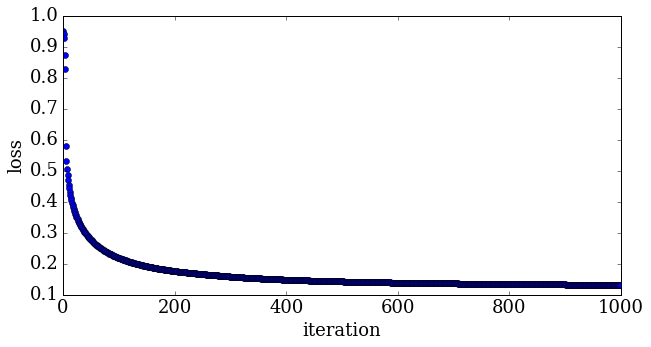

In [23]:
# visualize loss
plt.figure(figsize=(10,5))
plt.plot(logger['iteration'], logger['loss_iteration'],'ob', label="loss")

plt.xlabel('iteration')
plt.ylabel('loss');

In [24]:
def predict(x, model):
    """
    Prediction based on two-layer model
    
    Args:
        x (numpy.array): feature vector of a sample
         
    Returns:
        scalar: predicted class for this sample
    """    
    t = torch.from_numpy(x).type(dtype_torch)
    forward_pass = model(t)
    return np.argmax(forward_pass.data.numpy(), axis=1)

In [26]:
def get_accuracy(y, y_pred):
    """
    Calculate accuracy given y and y_predicted
    
    Args:
        y (numpy.array): ground truth
        y_pred (numpy.array): predictated values
         
    Returns:
        scalar: accuracy
    """
    n_samples = y.shape[0]
    return np.sum(y == y_pred)/n_samples * 100

In [27]:
y_train_predict = predict(dataX_train,model)
print("Train accuracy: %f" % get_accuracy(y_train_predict, dataY_train))

y_test_predict = predict(dataX_test, model)
print("Test accuracy: %f" % get_accuracy(y_test_predict, dataY_test))

Train accuracy: 95.238095
Test accuracy: 95.925926


## With our dataset

In [34]:
from sklearn import preprocessing
import pandas as pd

In [44]:
data=pd.read_csv("data/car_data/car.data", sep= ',', header= None)

le = preprocessing.LabelEncoder()
data = data.apply(le.fit_transform)
data = np.asarray(data)

In [45]:
print(data.shape)

(1728, 7)


In [46]:
dataX = data[:,0:6]
dataY = data[:,6]

In [53]:
n_samples = data.shape[0]
dim_in = 6 
dim_out = 4

n_train = int(n_samples * 0.7)
n_test = n_samples - n_train

In [54]:
# train-test partition
perm = np.random.permutation(n_samples)
train_indx = perm[:n_train]
test_indx = perm[n_train:]

dataX_train, dataY_train = dataX[train_indx,:], dataY[train_indx]
dataX_test, dataY_test = dataX[test_indx,:], dataY[test_indx]

In [55]:
dim_hidden1 = 100
dim_hidden2 = 150
model = Net(dim_in, dim_hidden1, dim_hidden2, dim_out)

In [56]:
x = torch.from_numpy(dataX_train).type(dtype_torch)
y = torch.from_numpy(dataY_train).type(torch.LongTensor)

In [57]:
learning_rate = 1e-2
n_iteration = 1000

In [58]:
logger = {}
logger['iteration'] = []
logger['loss_iteration'] = []

for t in range(n_iteration):  
    
    # forward pass
    y_pred = model(x)
    
    # compute loss
    loss = criterion(y_pred, y)

    # backprop
    loss.backward()

    # update weights using gradient descent  
    for param in model.parameters():
        param.data -= learning_rate * param.grad.data 
    
    # manually zero the gradients
    model.zero_grad()  
    
    # reporting & logging       
    if t % 100 == 0:
        print(t, loss.item())
        
    logger['iteration'] += [t]
    logger['loss_iteration'] += [loss.item()]

0 1.2677693367004395
100 0.7391719818115234
200 0.7179017066955566
300 0.7068893313407898
400 0.6992645859718323
500 0.6934142708778381
600 0.6884718537330627
700 0.6840059757232666
800 0.6798460483551025
900 0.675817608833313


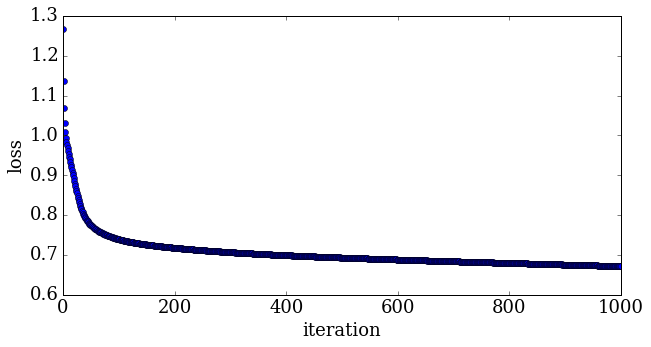

In [59]:
# visualize loss
plt.figure(figsize=(10,5))
plt.plot(logger['iteration'], logger['loss_iteration'],'ob', label="loss")

plt.xlabel('iteration')
plt.ylabel('loss');

In [60]:
y_train_predict = predict(dataX_train,model)
print("Train accuracy: %f" % get_accuracy(y_train_predict, dataY_train))

y_test_predict = predict(dataX_test, model)
print("Test accuracy: %f" % get_accuracy(y_test_predict, dataY_test))

Train accuracy: 70.140612
Test accuracy: 71.098266
